In [1]:
# start JVM
import weka.core.jvm as jvm
jvm.start(packages=True)

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['C:\\Users\\nptu\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\javabridge\\jars\\rhino-1.7R4.jar', 'C:\\Users\\nptu\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\javabridge\\jars\\runnablequeue.jar', 'C:\\Users\\nptu\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\javabridge\\jars\\cpython.jar', 'c:\\Users\\nptu\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\weka\\lib\\arpack_combined.jar', 'c:\\Users\\nptu\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\weka\\lib\\core.jar', 'c:\\Users\\nptu\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\weka\\lib\\mtj.jar', 'c:\\Users\\nptu\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\weka\\lib\\python-weka-wrapper.jar', 'c:\\Users\\nptu\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\weka\\lib\\weka.jar']
DEBUG:weka.core.jvm:MaxH

In [2]:
import weka.core.packages as packages

packages.install_package("timeseriesForecasting")
items = packages.installed_packages()
for item in items:
    print(item.name + " " + item.url)

timeseriesForecasting http://prdownloads.sourceforge.net/weka/timeseriesForecasting1.1.27.zip?download


In [3]:
from weka.timeseries import TSEvaluation, TSEvalModule, WekaForecaster,Periodicity
from weka.classifiers import Classifier
from weka.core.converters import Loader
from weka.core.dataset import Instances

def WekaTrain(file,Classifier_functions,test_split):
    # load a dataset

    airline_file="WekaData/"+file
    print("Loading dataset: " + airline_file)
    loader = Loader(classname="weka.core.converters.ArffLoader")
    airline_train = loader.load_file(airline_file)
    airline_train.class_is_last()

    # Classifier and Filter class names
    #  "weka.classifiers.functions.LinearRegression"

    forecaster = WekaForecaster()
    forecaster.base_forecaster = Classifier(classname=Classifier_functions)
    forecaster.fields_to_forecast ="Adj Close"
    forecaster.build_forecaster(airline_train)

    # tslag_maker
    forecaster.tslag_maker.add_day_of_week=True
    forecaster.tslag_maker.add_weekend_indicator=True

    forecaster.tslag_maker.remove_leading_instances_with_unknown_lag_values=True
    forecaster.tslag_maker.include_powers_of_time=True
    forecaster.tslag_maker.include_timelag_products=True

    forecaster.tslag_maker.timestamp_field ="Date"
    forecaster.tslag_maker.periodicity =Periodicity(periodicity="DAILY")

    forecaster.tslag_maker.max_lag=7
    forecaster.tslag_maker.min_lag=1



    # Prime the forecaster
    num_prime_instances = 7
    airline_prime = Instances.copy_instances(airline_train, airline_train.num_instances - num_prime_instances, num_prime_instances)
    forecaster.prime_forecaster(airline_prime)

    
    evaluation = TSEvaluation(airline_train,test_split)

    evaluation.evaluate_on_training_data = True
    evaluation.evaluate_on_test_data = True
    evaluation.prime_window_size = forecaster.tslag_maker.max_lag
   


    evaluation.prime_for_test_data_with_test_data = False
    evaluation.rebuild_model_after_each_test_forecast_step = False
    evaluation.forecast_future = True

    forecast_future_num=1
    evaluation.horizon = forecast_future_num
    evaluation.evaluation_modules = "MAE,MAPE,RMSE"
    evaluation.evaluate(forecaster)
    

    return evaluation.summary()
    


In [5]:
WekaTrain('BTC-all.arff',"weka.classifiers.functions.LinearRegression",0.3)

Loading dataset: WekaData/BTC-all.arff


'=== Evaluation on training data ===\nTarget                             1-step-ahead\n===============================================\nAdj Close\n  N                                        2268\n  Mean absolute error                  137.7124\n  Mean absolute percentage error         3.1697\n  Root mean squared error              289.4985\n\nTotal number of instances: 2275\n\n=== Evaluation on test data ===\nTarget                             1-step-ahead\n===============================================\nAdj Close\n  N                                         975\n  Mean absolute error                  956.6456\n  Mean absolute percentage error          2.715\n  Root mean squared error             1394.8989\n\nTotal number of instances: 975\n\n'

In [8]:
import pandas as pd
# 'ETH-all.arff','ETH-N2Y.arff','ETH-N4Y.arff'
Arff_list=['BTC-all.arff','BTC-N2Y.arff','BTC-N4Y.arff']

Classifier_list=["weka.classifiers.functions.LinearRegression",
                "weka.classifiers.functions.SMOreg",
                "weka.classifiers.trees.RandomForest"]
Split_list=[0.3,0.2,0.1,7]

Arff=list()
Classifiers=list()
Split=list()
train_num=list()
train_mae=list()
train_mape=list()
train_rmse=list()
test_num=list()
test_mae=list()
test_mape=list()
test_rmse=list()



for arff in Arff_list:
    for classifiers in Classifier_list:
        for split in Split_list:
            print(classifiers)
            summary=WekaTrain(arff,classifiers,split)
            Arff.append(arff)
            Classifiers.append(classifiers)
            Split.append(str(split))

            train_num.append(summary.split('\n')[4].split(' ')[-1])
            train_mae.append(summary.split('\n')[5].split(' ')[-1])
            train_mape.append(summary.split('\n')[6].split(' ')[-1])
            train_rmse.append(summary.split('\n')[7].split(' ')[-1])

            test_num.append(summary.split('\n')[15].split(' ')[-1])
            test_mae.append(summary.split('\n')[16].split(' ')[-1])
            test_mape.append(summary.split('\n')[17].split(' ')[-1])
            test_rmse.append(summary.split('\n')[18].split(' ')[-1])

Summary={'Data':Arff,'Classifier':Classifier,'Test Split':Split,
            'train_num':train_num,
            'train_mae':train_mae,
            'train_mape':train_mape,
            'train_rmse':train_rmse,
            'test_num':test_num,
            'test_mae':test_mae,
            'test_mape':test_mape,
            'test_rmse':test_rmse}

df_Summary = pd.DataFrame(Summary)
df_Summary.to_excel("Summary.xlsx")  

BTC-N2Y.arff

weka.classifiers.functions.LinearRegression
Loading dataset: WekaData/BTC-all.arff
weka.classifiers.functions.LinearRegression
Loading dataset: WekaData/BTC-all.arff
weka.classifiers.functions.LinearRegression
Loading dataset: WekaData/BTC-all.arff
weka.classifiers.functions.LinearRegression
Loading dataset: WekaData/BTC-all.arff
weka.classifiers.functions.SMOreg
Loading dataset: WekaData/BTC-all.arff
weka.classifiers.functions.SMOreg
Loading dataset: WekaData/BTC-all.arff
weka.classifiers.functions.SMOreg
Loading dataset: WekaData/BTC-all.arff
weka.classifiers.functions.SMOreg
Loading dataset: WekaData/BTC-all.arff
weka.classifiers.trees.RandomForest
Loading dataset: WekaData/BTC-all.arff
weka.classifiers.trees.RandomForest
Loading dataset: WekaData/BTC-all.arff
weka.classifiers.trees.RandomForest
Loading dataset: WekaData/BTC-all.arff
weka.classifiers.trees.RandomForest
Loading dataset: WekaData/BTC-all.arff
weka.classifiers.functions.LinearRegression
Loading dataset: WekaData/BTC-N2

### Test Predictions for Target Figure

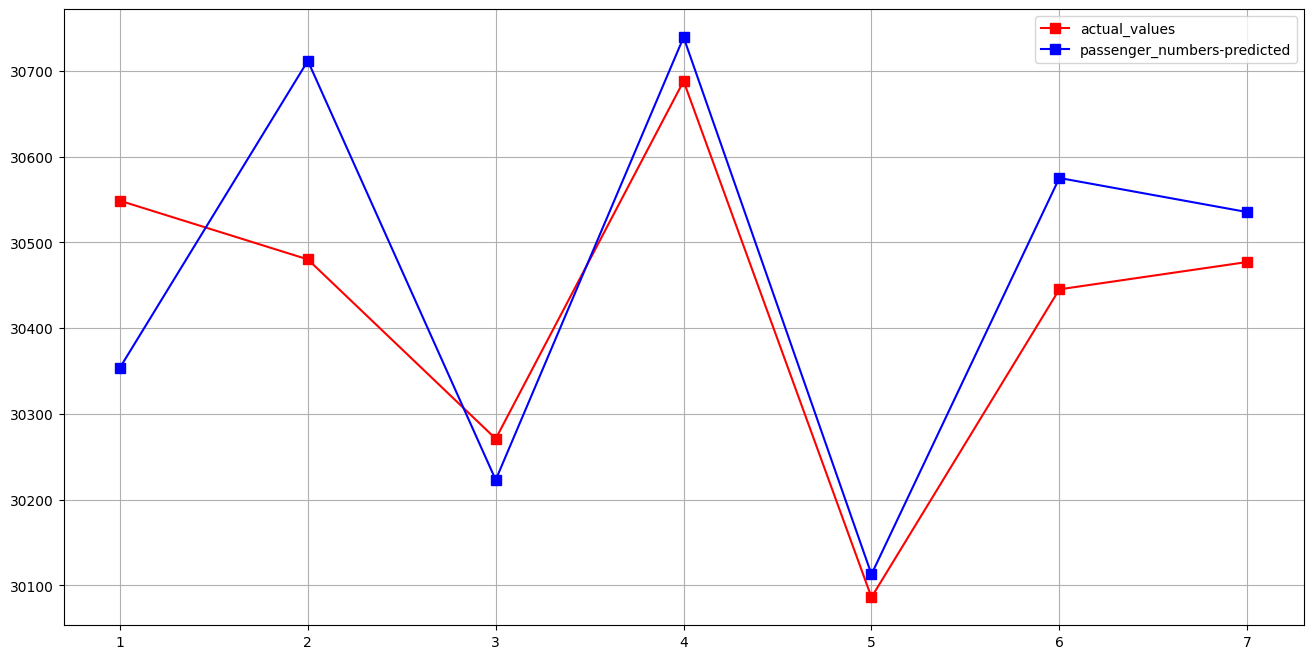

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import matplotlib.dates as mdates
import pandas as pd

#actual values and Time on test
actual_values_test=list()
predicted_values_test=list()
future_values_time=list()
future_forecast_test=evaluation.print_predictions_for_test_data("Predictions (test)", "Adj Close", 1).split('\n')
for x in range(3,len(future_forecast_test)-1):
    actual_values_test.append(float(future_forecast_test[x].split()[1]))
    predicted_values_test.append(float(future_forecast_test[x].split()[2]))
    future_values_time.append(float(future_forecast_test[x].split()[0]))
plt.figure(figsize=(16,8))
plt.grid(True)

# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=200))


plt.plot(future_values_time,actual_values_test,color='red',marker="s",markersize="7")
plt.plot(future_values_time,predicted_values_test,color='blue',marker="s",markersize="7")

plt.legend(['actual_values','passenger_numbers-predicted'])
# plt.savefig('figure/1.4 Looking at forecasts-4.png')
plt.show()


### Train Predictions for Target Figure

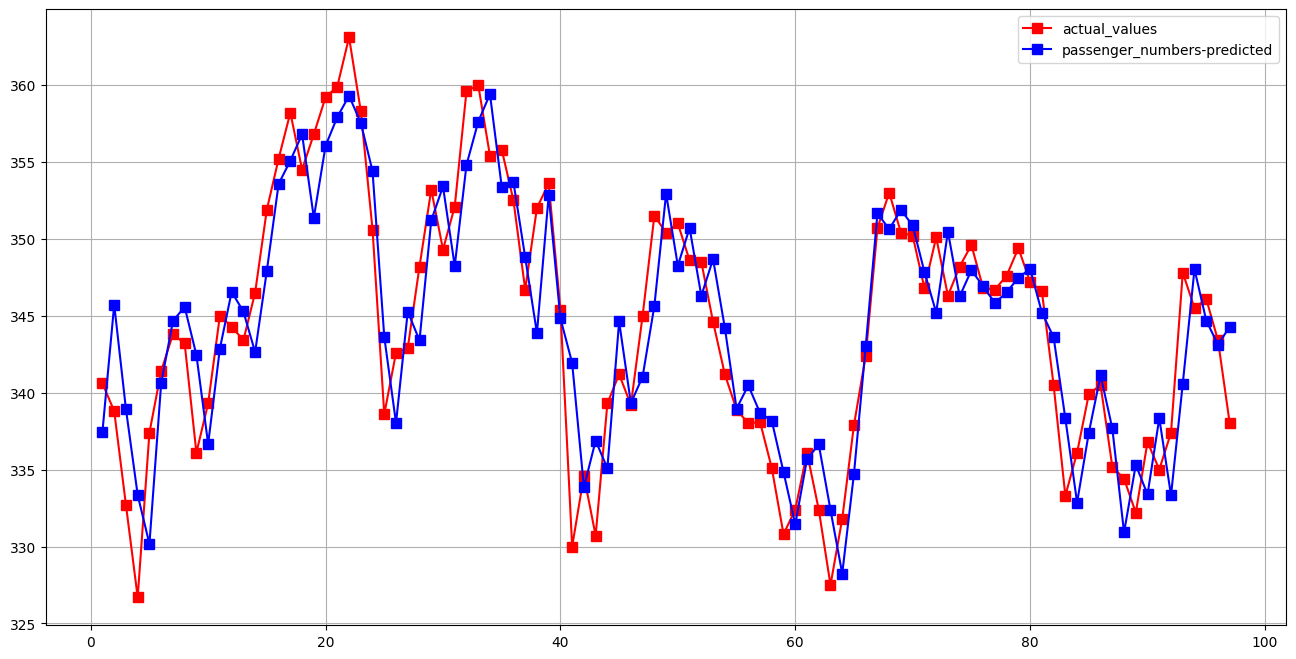

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import matplotlib.dates as mdates
import pandas as pd

#actual values and Time on test
actual_values_test=list()
predicted_values_test=list()
future_values_time=list()

future_forecast_test=evaluation.print_predictions_for_training_data("Predictions (training)", "Close", 1).split('\n')
for x in range(3,len(future_forecast_test)-1):
    actual_values_test.append(float(future_forecast_test[x].split()[1]))
    predicted_values_test.append(float(future_forecast_test[x].split()[2]))
    future_values_time.append(float(future_forecast_test[x].split()[0]))


plt.figure(figsize=(16,8))
plt.grid(True)
plt.plot(future_values_time,actual_values_test,color='red',marker="s",markersize="7")
plt.plot(future_values_time,predicted_values_test,color='blue',marker="s",markersize="7")
plt.legend(['actual_values','passenger_numbers-predicted'])
# plt.savefig('figure/1.4 Looking at forecasts-4.png')
plt.show()


### Test Future Predictions for Target Figure

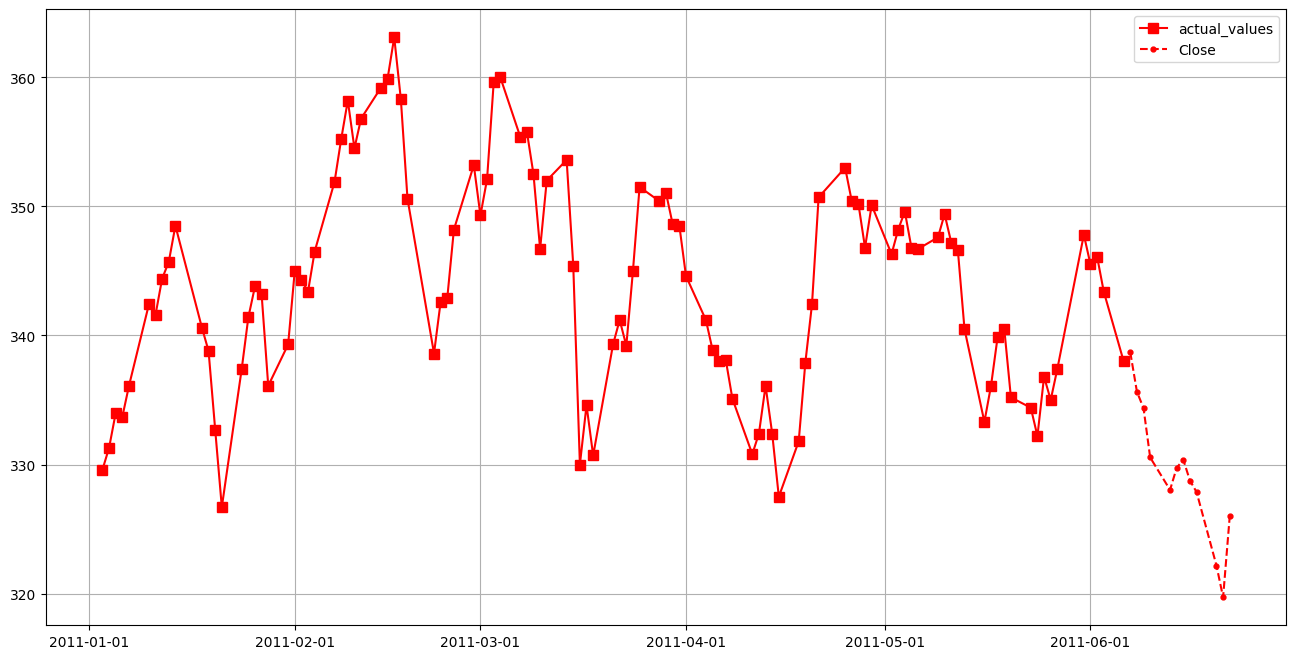

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import matplotlib.dates as mdates
import pandas as pd

#actual values and Time
actual_values=list()
actual_values_time=list()
future_forecast=evaluation.print_future_forecast_on_training_data(forecaster).split('\n')
for x in range(1,len(future_forecast)-1-forecast_future_num):
    actual_values_time.append(future_forecast[x].split()[0])
    actual_values.append(float(future_forecast[x].split()[1]))

#future values and Time
future_values=list()
future_values_time=list()
future_forecast=evaluation.print_future_forecast_on_training_data(forecaster).split('\n')
for x in range(len(future_forecast)-1-forecast_future_num,len(future_forecast)-1):
    future_values_time.append(future_forecast[x].split()[0].strip('*'))
    future_values.append(float(future_forecast[x].split()[1]))

actual_time_stamp=[datetime.strptime(d,"%Y-%m-%d").date() for d in actual_values_time]
future_time_stamp=[datetime.strptime(d,"%Y-%m-%d").date() for d in future_values_time]

plt.figure(figsize=(16,8))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))

plt.grid(True)
plt.plot(actual_time_stamp,actual_values,color='red',marker="s",markersize="7")
plt.plot(future_time_stamp,future_values,color='red',marker=".",linestyle="--",markersize="7")
plt.legend(['actual_values','Close'])
# plt.savefig('figure/1.4 Looking at forecasts-4.png')
plt.show()


In [8]:
jvm.stop()